# 概要
学習済みのモデルを使って、歌詞からアーティスト名の予測＆LIMEによる解釈を可視化します。

# 準備

In [1]:
%%capture
!pip install japanize-matplotlib
!pip install lime
!pip install janome

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
import os
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

from lime.lime_text import LimeTextExplainer

from IPython.display import display, HTML
from janome.tokenizer import Tokenizer
import unicodedata

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# 保存先のパス
PATH = '..'

In [4]:
class CharacterCNN(nn.Module):
    def __init__(self, num_classes ,embed_size=128, max_length=200, filter_sizes=(2, 3, 4, 5), filter_num=64):
        super().__init__()
        self.params = {'num_classes': num_classes ,'embed_size':embed_size, 'max_length':max_length, 'filter_sizes':filter_sizes, 'filter_num':filter_num}
        self.embed_size = embed_size
        self.max_length = max_length
        self.filter_sizes = filter_sizes
        self.filter_num = filter_num

        self.embedding = nn.Embedding(0xffff, embed_size)
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(embed_size, filter_num, filter_size) for filter_size in filter_sizes
        ])
        self.fc1 = nn.Linear(filter_num * len(filter_sizes), 64)
        self.batch_norm = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        embedded = self.embedding(x).transpose(1,2)

        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_output = F.relu(conv_layer(embedded))
            pooled = F.max_pool1d(conv_output, conv_output.size(2)).squeeze(2)
            conv_outputs.append(pooled)

        convs_merged = torch.cat(conv_outputs, dim=1)
        fc1_output = F.relu(self.fc1(convs_merged))
        bn_output = self.batch_norm(fc1_output)
        do_output = self.dropout(bn_output)
        fc2_output = self.fc2(do_output)
        return fc2_output

class CharacterCNNEmbedding(nn.Module):
    def __init__(self, embed_size=256):
        super().__init__()
        self.embed_size = embed_size
        self.embedding = nn.Embedding(0xffff, embed_size)

    def forward(self, x):
        embedded = self.embedding(x).transpose(1,2)
        return embedded

class CharacterCNNClassifier(nn.Module):
    def __init__(self, num_classes, embed_size=256, filter_sizes=(2, 3, 4, 5), filter_num=64):
        super().__init__()
        self.embed_size = embed_size
        self.filter_sizes = filter_sizes
        self.filter_num = filter_num

        self.conv_layers = nn.ModuleList([
            nn.Conv1d(embed_size, filter_num, filter_size) for filter_size in filter_sizes
        ])
        self.fc1 = nn.Linear(filter_num * len(filter_sizes), 64)
        self.batch_norm = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_output = F.relu(conv_layer(x))
            pooled = F.max_pool1d(conv_output, conv_output.size(2)).squeeze(2)
            conv_outputs.append(pooled)

        convs_merged = torch.cat(conv_outputs, dim=1)
        fc1_output = F.relu(self.fc1(convs_merged))
        bn_output = self.batch_norm(fc1_output)
        do_output = self.dropout(bn_output)
        fc2_output = self.fc2(do_output)
        return fc2_output

In [5]:
def encode(txt, max_length=200):
    """歌詞の1文字1文字をUnicodeに変換する関数"""
    txt_list = []
    for l in txt:
        txt_line = [ord(x) for x in str(l).strip()]
        txt_line = txt_line[:max_length]
        txt_len = len(txt_line)
        if txt_len < max_length:
            txt_line += ([0] * (max_length - txt_len))
        txt_list.append((txt_line))
    return np.array(txt_list)

# モデルの読み込み

In [61]:
SelectALL = False  #@param  {type:"boolean"}

YOASOBI = True  #@param  {type:"boolean"}
スピッツ = True  #@param  {type:"boolean"}
Mr_Children = True  #@param  {type:"boolean"}
米津玄師 = True  #@param  {type:"boolean"}
SEKAI_NO_OWARI = True  #@param  {type:"boolean"}
あいみょん = True  #@param  {type:"boolean"}
King_Gnu = False  #@param  {type:"boolean"}
Mrs_GREEN_APPLE = False  #@param  {type:"boolean"}
Official髭男dism = True  #@param  {type:"boolean"}
安室奈美恵 = False  #@param  {type:"boolean"}
back_number = True  #@param  {type:"boolean"}
ヨルシカ = False  #@param  {type:"boolean"}
BUMP_OF_CHICKEN = False  #@param  {type:"boolean"}
ONE_OK_ROCK = False  #@param  {type:"boolean"}
RADWIMPS = True  #@param  {type:"boolean"}
Bz = False  #@param  {type:"boolean"}
ゆず = True  #@param  {type:"boolean"}
嵐 = False  #@param  {type:"boolean"}
GreeeeN = False  #@param  {type:"boolean"}
サザンオールスターズ = False  #@param  {type:"boolean"}
宇多田ヒカル = False  #@param  {type:"boolean"}
星野源 = True  #@param  {type:"boolean"}
ポルノグラフィティ = False  #@param  {type:"boolean"}
Eve = False  #@param  {type:"boolean"}
Ado = False  #@param  {type:"boolean"}
BTS = False  #@param  {type:"boolean"}
中島みゆき = False  #@param  {type:"boolean"}
緑黄色社会 = False  #@param  {type:"boolean"}
倖田來未 = False  #@param  {type:"boolean"}
優里 = False  #@param  {type:"boolean"}
いきものがかり = False  #@param  {type:"boolean"}
ZARD = False  #@param  {type:"boolean"}
椎名林檎 = False  #@param  {type:"boolean"}
小田和正 = False  #@param  {type:"boolean"}
TWICE = False  #@param  {type:"boolean"}
Perfume = False  #@param  {type:"boolean"}
Uru = False  #@param  {type:"boolean"}
Superfly = False  #@param  {type:"boolean"}
aiko = False  #@param  {type:"boolean"}
Aimer = False  #@param  {type:"boolean"}
三代目_J_SOUL_BROTHERS = False  #@param  {type:"boolean"}

select_artist = {
"YOASOBI":YOASOBI,
"スピッツ":スピッツ,
"Mr.Children":Mr_Children,
"米津玄師":米津玄師,
"SEKAI NO OWARI":SEKAI_NO_OWARI,
"あいみょん":あいみょん,
"King Gnu":King_Gnu,
"Mrs. GREEN APPLE":Mrs_GREEN_APPLE,
"Official髭男dism":Official髭男dism,
"安室奈美恵":安室奈美恵,
"back number":back_number,
"ヨルシカ":ヨルシカ,
"BUMP OF CHICKEN":BUMP_OF_CHICKEN,
"ONE OK ROCK":ONE_OK_ROCK,
"RADWIMPS":RADWIMPS,
"B'z":Bz,
"ゆず":ゆず,
"嵐":嵐,
"GreeeeN":GreeeeN,
"サザンオールスターズ":サザンオールスターズ,
"宇多田ヒカル":宇多田ヒカル,
"星野源":星野源,
"ポルノグラフィティ":ポルノグラフィティ,
"Eve":Eve,
"Ado":Ado,
"BTS":BTS,
"中島みゆき":中島みゆき,
"緑黄色社会":緑黄色社会,
"倖田來未":倖田來未,
"優里":優里,
"いきものがかり":いきものがかり,
"ZARD":ZARD,
"椎名林檎":椎名林檎,
"小田和正":小田和正,
"TWICE":TWICE,
"Perfume":Perfume,
"Uru":Uru,
"Superfly":Superfly,
"aiko":aiko,
"Aimer":Aimer,
"三代目 J SOUL BROTHERS":三代目_J_SOUL_BROTHERS}

if SelectALL:
    for k in select_artist.keys():
        select_artist[k] = True

In [62]:
print('Loading models...')

# Embeddingの読み込み
state_dict = torch.load(PATH + '/pretrain/model_fold1.pth', map_location=device)
state_dict = OrderedDict(list(state_dict.items())[0:1])
embed = CharacterCNNEmbedding().to(device)
embed.load_state_dict(state_dict)

# Classifierの読み込み
classifier = dict()
for artist in tqdm(os.listdir(PATH + '/models')):
    if select_artist[artist]:
        model_list = []
        for file in os.listdir(PATH + '/models/'+ artist):
            state_dict = torch.load(PATH + '/models/'+ artist + '/' +file, map_location=device)
            clf = CharacterCNNClassifier(2).to(device)
            clf.load_state_dict(state_dict)
            model_list.append(clf)
        classifier[artist] = model_list

artists = list(classifier.keys())
explainer = LimeTextExplainer(class_names=artists)

Loading models...


100%|██████████| 41/41 [00:01<00:00, 21.97it/s]


# 便利関数の定義

In [27]:
def predict_one_block(txt):
    """歌詞1ブロックに対する予測を行う関数
    txt[string] : 歌詞1ブロック分

    --> 各アーティストに対する確率値の配列(1次元)
    """
    global embed, classifier
    txt = txt.strip().replace('\n','*').replace('\u3000','*')
    txt_enc = torch.from_numpy(encode([txt]))
    txt_emb = embed(txt_enc.to(device))
    probs = []
    for artist,model_list in classifier.items():
        probs_fold = []
        for model in model_list:
            with torch.no_grad():
                model.eval()
                output = model(txt_emb)
                probs_fold.append(output.softmax(dim=1).cpu().numpy()[0])
        probs.append(np.array(probs_fold).mean(axis=0))
    prob = np.array(probs)[:,1]
    return prob

def predict_some_block(txt_list):
    """歌詞ブロックのリストに対する予測を行う関数
    txt_list[list] : 歌詞1ブロックを1要素とするリスト

    --> 各アーティストに対する確率値の配列。(txt_listの長さ, 全アーティスト数)の2次元配列
    """
    global embed, classifier
    txt_arr = []
    for txt in txt_list:
        txt = txt.replace(' ','')
        txt = txt.strip().replace('\n','*').replace('\u3000','*')
        txt_arr.append(txt)
    txt_enc = torch.from_numpy(encode(txt_arr))
    txt_emb = embed(txt_enc.to(device))
    probs = []
    for artist,model_list in classifier.items():
        probs_fold = []
        for model in model_list:
            with torch.no_grad():
                model.eval()
                output = model(txt_emb)
                probs_fold.append(output.softmax(dim=1).cpu().numpy())
        probs.append(np.array(probs_fold).mean(axis=0))
    probs = np.array(probs)[:,:,1].transpose(1,0)
    return probs

def predict_whole_song(txt_list):
    """1曲のリストに対する予測を行う関数
    txt_list[list] : 1曲の歌詞を1要素とするリスト。ただし1曲の歌詞は'\n\n'によりブロックで分割されていること。

    --> 各アーティストに対する確率値の配列。(txt_listの長さ, 全アーティスト数)の2次元配列
    """
    prob_arr = []
    for txt in txt_list:
        prob_arr.append(predict_some_block(txt.split('\n\n')).mean(axis=0))
    return np.array(prob_arr)

def show_predict_one_block(prob, artists, sort, figsize=(10,3)):
    """予測結果を可視化する関数(歌詞ブロック版)"""
    if sort:
        order = np.argsort(prob)[::-1]
        prob = np.array(prob)[order]
        artists = np.array(artists)[order]

    plt.figure(figsize=figsize)
    plt.bar(artists, prob, color='green', zorder=100)
    for i,p in enumerate(prob):
        plt.text(i, p+0.05, f'{int(p*100)}%', horizontalalignment='center', zorder=100)
    plt.xticks(rotation=90)
    plt.ylim(0,1)
    plt.grid()
    plt.show()

def show_predict_whole_song(prob_arr, artists, sort, raw_txt_arr, figsize=(10,7)):
    """予測結果を可視化する関数(歌詞全体版)"""
    fig,axs = plt.subplots(2,1, figsize=figsize)
    # 予測値の平均
    prob_mean = prob_arr.mean(axis=0)
    if sort:
        order = np.argsort(prob_mean)[::-1]
        prob_mean = np.array(prob_mean)[order]
        artists_sort = np.array(artists)[order]

    axs[0].bar(artists_sort, prob_mean, color='green', zorder=100)
    for i,p in enumerate(prob_mean):
        axs[0].text(i, p+0.05, f'{int(p*100)}%', horizontalalignment='center', zorder=100)
    axs[0].set_xticks(range(len(artists_sort)), labels=artists_sort, rotation=90)
    axs[0].set_ylim(0,1)
    axs[0].grid()
    axs[0].set_title('平均値')

    # 各ブロックの予測値
    prob_norm = prob_arr / np.repeat(prob_arr.sum(axis=1).reshape(-1,1), prob_arr.shape[1], axis=1)
    raw_txt_arr = [raw_txt[:5] for raw_txt in raw_txt_arr]
    df = pd.DataFrame(prob_norm, columns=artists, index=raw_txt_arr)
    df.plot.bar(stacked=True, cmap='tab20c', ax=axs[1], zorder=100)
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[1].set_xticks(range(len(df.index)), labels=df.index, rotation=90)
    axs[1].set_xlabel('')
    axs[1].grid()
    axs[1].legend(ncol=2, bbox_to_anchor=(1, 0.5), loc='center left', fontsize=10)
    axs[1].set_title('各ブロックの予測値')
    plt.tight_layout()
    plt.show()

def wakachi_one_block(txt):
    """日本語テキストを分かち書きする(歌詞ブロック版)"""
    txt = txt.replace('\u3000','')
    tokenizer = Tokenizer()
    tokens = tokenizer.tokenize(txt)
    words = [token.surface for token in tokens]
    txt_split = []
    line = []
    for i,word in enumerate(words):
        if word == '\n':
            txt_split.append(' '.join(line))
            line = []
        else:
            line.append(word)
    txt_split.append(' '.join(line))
    return '\n'.join(txt_split)

def wakachi_some_block(txt):
    """日本語テキストを分かち書きする(歌詞全体版)"""
    wakachi_txt = ''
    for block in txt.split('\n\n'):
        wakachi_txt += wakachi_one_block(block) + '\n\n'
    return wakachi_txt

def highlight(exp, wakachi_txt, sort_by=False):
    """LIMEの結果をハイライト表示"""
    highlighted_text = '<h2><span style="color: black; background-color: rgba(255,128,0,1);">ぽい</span> / <span style="color: black; background-color: rgba(0,128,255,1);">ぽくない</span>判定理由</h2>'

    if sort_by is not False:
        order = np.argsort(sort_by)[::-1]
        artist_labels = np.arange(len(artists))[order]
    else:
        artist_labels = range(len(artists))
    for label in artist_labels:
        words = [word for word, weight in exp.as_list(label)]
        weights = np.array([weight for word, weight in exp.as_list(label)])
        weights_alpha = weights / np.abs(weights).max()
        alpha_dict = {word:alpha for word,alpha in zip(words,weights_alpha)}

        highlighted_text += f'<h3>「{artists[label]}」っぽさ</h3><div style="overflow:auto; max-height:300px; max-width:600px;border: 2px solid black; padding: 20px; box-sizing: border-box"><p style="line-height: 2;">'
        for line in wakachi_txt.split('\n'):
            for word in line.split(' '):
                try:
                    alpha = alpha_dict[word]
                    if alpha > 0:
                        bg_color = (255,128,0,alpha)
                    else:
                        bg_color = (0,128,255,-alpha)
                    highlighted_text += f'<span style="color: black; background-color: rgba{bg_color};">{word}</span> '
                except KeyError:
                    highlighted_text += word
            highlighted_text += '<br>'
        highlighted_text += '</p></div><br>'
    return highlighted_text

# 推論と解釈

## 1ブロック分の歌詞
- `txt`に歌詞1ブロック分を入力してください。
- `figsize`でグラフのサイズを調整できます。
- `num_samples`で、LIMEにおいてサンプルする近傍店の個数を指定できます。値が大きいほどLIMEの計算に時間がかかります。
- LIME表示用の分かち書きは自動生成されますが、`wakachi_txt`(カスタム分かち書き)に自分で分かち書きした歌詞も入れることができます。`txt`に入力した歌詞を**半角スペース**で分かち書きしたものを入れてください。

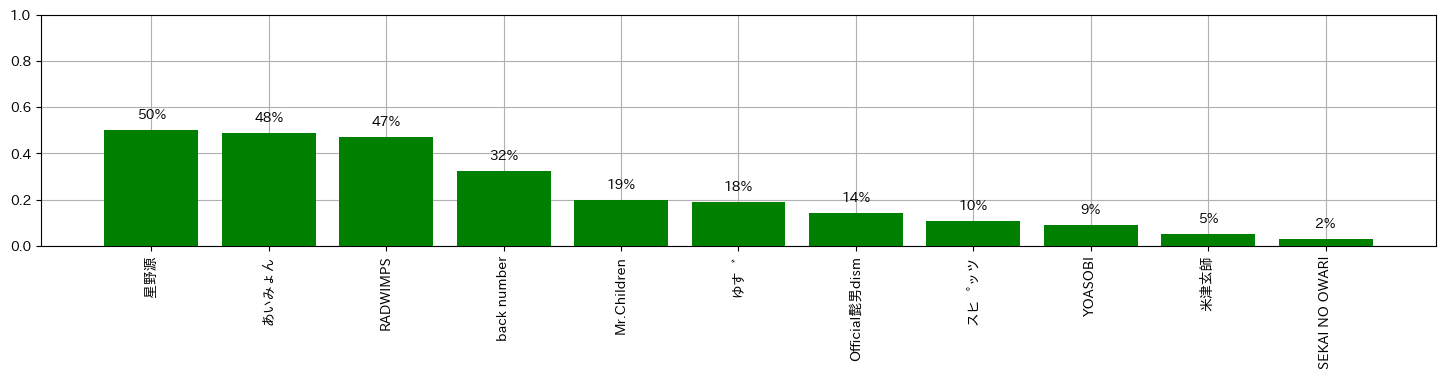

In [63]:
txt = """これが最後の恋でも
理解はできるだろう
せめて　それまでは
ふたりで　ふたりで
たぶらかして生きていよう
ダメに成る時は成るでしょう
せめて　それまでは　ふたり"""

figsize = (18,3)  # グラフのサイズを調整 (横,縦)
num_samples = 1000  # サンプルする近傍点の個数

# 分類結果の取得
prob = predict_one_block(txt)
# 棒グラフで可視化
show_predict_one_block(prob, artists, sort=True, figsize=figsize)

# カスタム分かち書き ###############
wakachi_txt = """
"""

# LIME
if wakachi_txt == '\n':
    wakachi_txt = wakachi_one_block(txt)
exp = explainer.explain_instance(wakachi_txt, predict_some_block, num_features=len(wakachi_txt.split()), labels=range(len(artists)), num_samples=num_samples)
highlighted_text = highlight(exp, wakachi_txt, prob)
display(HTML(highlighted_text))

## 歌詞全体
- `txt`に歌詞全体を入力してください。ブロック間は改行を1つはさんでください。
- `figsize`でグラフのサイズを調整できます。
- `num_samples`で、LIMEにおいてサンプルする近傍点の個数を指定できます。値が大きいほどLIMEの計算に時間がかかります。

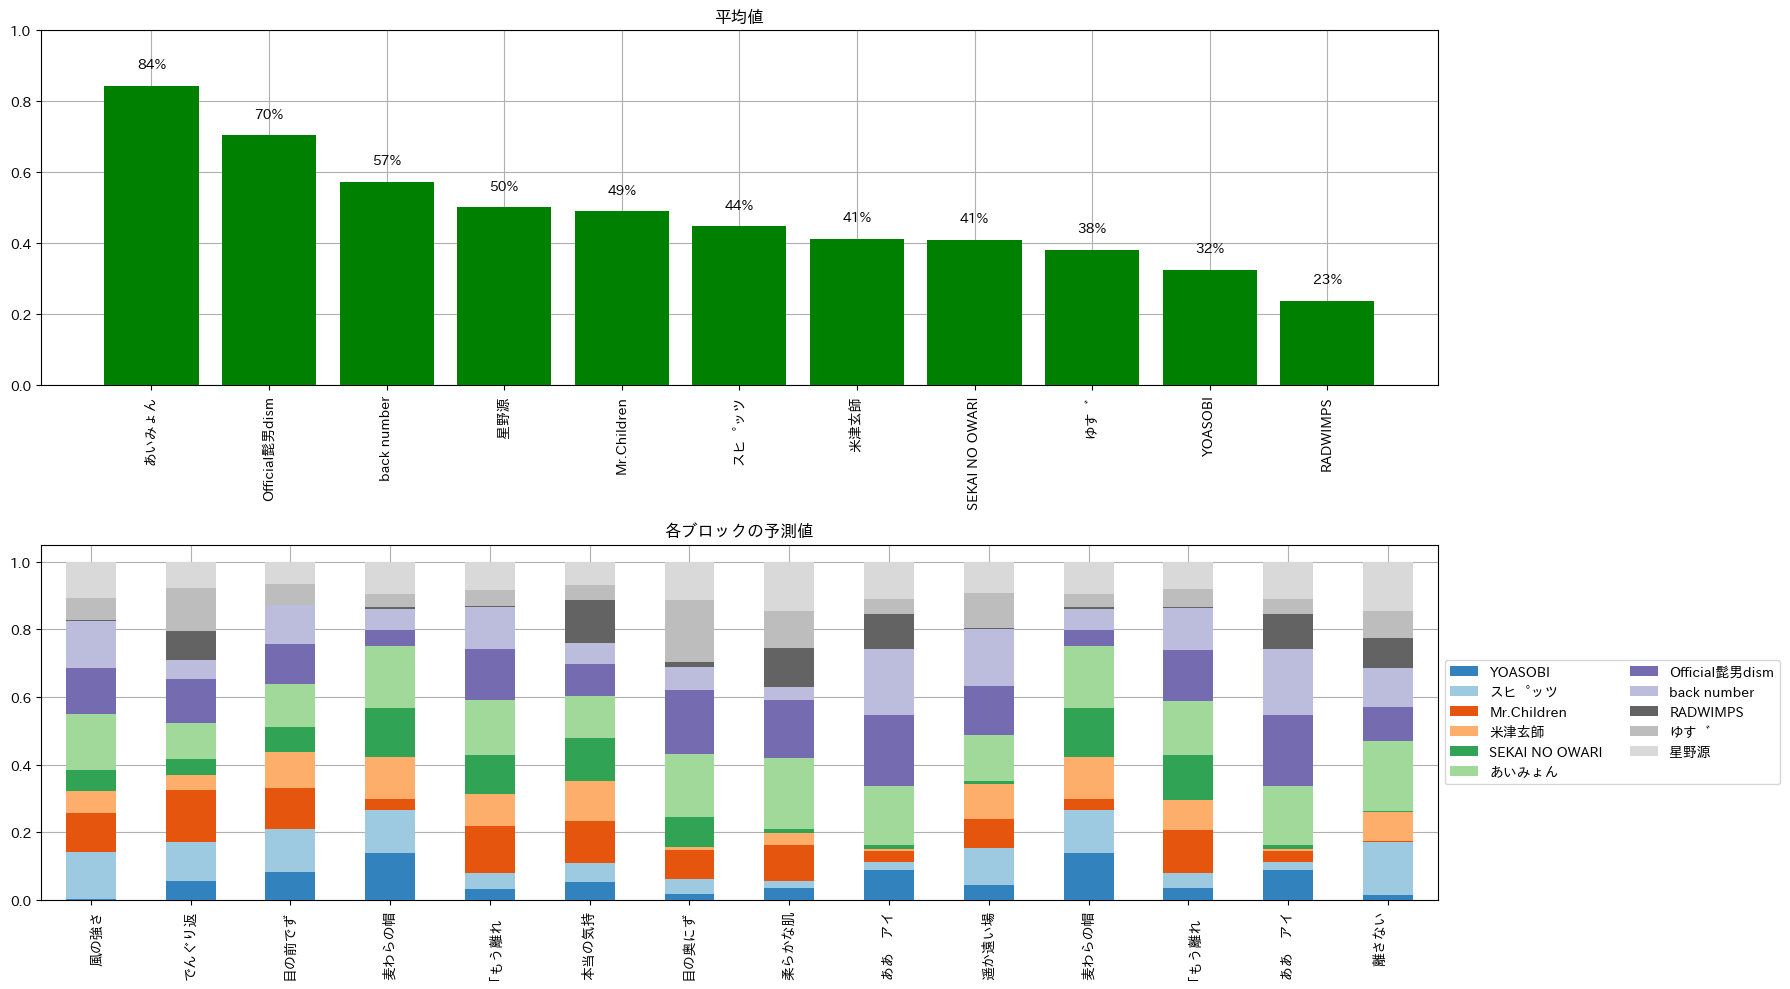

In [64]:
txt = """
風の強さがちょっと
心を揺さぶりすぎて
真面目に見つめた
君が恋しい

でんぐり返しの日々
可哀想なふりをして
だらけてみたけど
希望の光は

目の前でずっと輝いている
幸せだ

麦わらの帽子の君が
揺れたマリーゴールドに似てる
あれは空がまだ青い夏のこと
懐かしいと笑えたあの日の恋

「もう離れないで」と
泣きそうな目で見つめる君を
雲のような優しさでそっとぎゅっと
抱きしめて　抱きしめて　離さない

本当の気持ち全部
吐き出せるほど強くはない
でも不思議なくらいに
絶望は見えない

目の奥にずっと写るシルエット
大好きさ

柔らかな肌を寄せあい
少し冷たい空気を2人
かみしめて歩く今日という日に
何と名前をつけようかなんて話して

ああ　アイラブユーの言葉じゃ
足りないからとキスして
雲がまだ2人の影を残すから
いつまでも　いつまでも　このまま

遥か遠い場所にいても
繋がっていたいなあ
2人の想いが
同じでありますように

麦わらの帽子の君が
揺れたマリーゴールドに似てる
あれは空がまだ青い夏のこと
懐かしいと笑えたあの日の恋

「もう離れないで」と
泣きそうな目で見つめる君を
雲のような優しさでそっとぎゅっと
抱きしめて離さない

ああ　アイラブユーの言葉じゃ
足りないからとキスして
雲がまだ2人の影を残すから
いつまでも　いつまでも　このまま

離さない
いつまでも　いつまでも　離さない
"""
figsize = (18,10)  # グラフのサイズを調整 (横,縦)
num_samples = 100  # サンプルする近傍点の個数

# 分類結果の取得
prob = predict_some_block(txt.split('\n\n'))

# 100%積み上げ棒グラフで可視化
show_predict_whole_song(prob, artists, sort=True, raw_txt_arr=txt.split('\n\n'), figsize=figsize)

# LIME
wakachi_txt = wakachi_some_block(txt)
exp = explainer.explain_instance(wakachi_txt, predict_whole_song, num_features=len(wakachi_txt.split()), labels=range(len(artists)), num_samples=num_samples)
highlighted_text = highlight(exp, wakachi_txt, prob.mean(axis=0))
display(HTML(highlighted_text))